In [1]:
canvas_config = {
    'start_x' :30,
    'start_y' : 750,
    'token_spacing' : 100,
    'line_spacing' : 8,
  'count' : 0,
  'key_spacing' : 200,
  'header_spacing' : 15,
  'section_spacing' : 50,
  'line_break' : 20
}

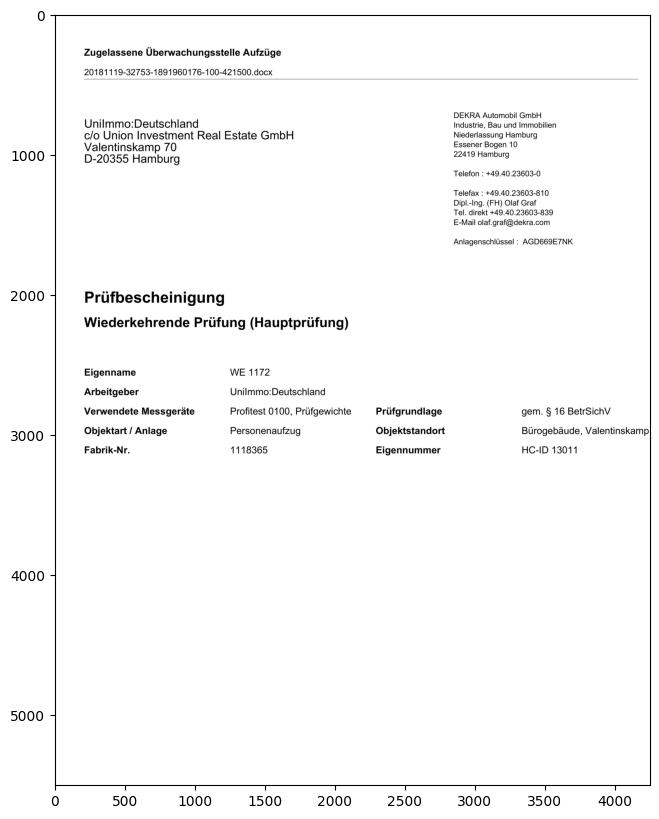

In [1]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen.canvas import Canvas as Canvas
import cv2
import matplotlib.pyplot as plt 
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from PIL import Image
from pdf2image import convert_from_path
from reportlab.lib.colors import HexColor
from reportlab.lib import colors
import os
from reportlab.lib.utils import ImageReader
from reportlab.lib.units import inch
import numpy as np
from reportlab.lib.pagesizes import A4
import random

# register the TTF font file
pdfmetrics.registerFont(TTFont('Arial', 'arial.ttf'))
pdfmetrics.registerFont(TTFont('Arial-Bold', 'arialbd.ttf'))

header = 'Zugelassene Überwachungsstelle Aufzüge'
file_name = '20181119-32753-1891960176-100-421500.docx'
page_no = 'Seite 1 von 1'

client_address = {
  'line1' : 'UniImmo:Deutschland',
  'line2' : 'c/o Union Investment Real Estate GmbH',
  'line3' : 'Valentinskamp 70',
  'line4' : 'D-20355 Hamburg'
}

client_address_config ={
  'font' : 'Arial',
  'line_break' : 12,
  'font_size' : 12
}

evaluator_address = {
  'address' :{
    'line1' : 'DEKRA Automobil GmbH',
    'line2' : 'Industrie, Bau und Immobilien',
    'line3' : 'Niederlassung Hamburg',
    'line4' : 'Essener Bogen 10',
    'line5' : '22419 Hamburg'
    },
  'Telefon' : '+49.40.23603-0',
  'Telefax' : '+49.40.23603-810',
  'Kontakt' : {
    'line1' : 'Dipl.-Ing. (FH) Olaf Graf',
    'line2' :'Tel. direkt +49.40.23603-839',
    'line3' : 'E-Mail olaf.graf@dekra.com',
  },
  
  'Anlagenschlüssel' : ' AGD669E7NK'
}

evaluator_address_config = {
  'font':'Arial',
  'line_break' : 10,
  'font_size' : 8,
  'new_line':['Telefax', 'kontakt']
}

test_certificate = {
  'Prüfbescheinigung' : 'Wiederkehrende Prüfung (Hauptprüfung)'
}

test_certificate_config = {
  'font_size' : 16,
  'font_type': 'Arial-Bold',
  'line-break' : 25 # should be 25-30
}

test_certificate_results = {
  'Prüfgrundlage' : 'gem. § 16 BetrSichV', #Str some code related to legal documents
  'Objektstandort' : 'Bürogebäude, Valentinskamp 70, 20355 Hamburg, Aufzug E', #str address
  'Objektart / Anlage' : 'Personenaufzug', #Str type of elevator
  'Fabrik-Nr.' : '1118365', #long 6-9 digits
  'Arbeitgeber' : client_address['line1'],
  'Eigennummer' : 'HC-ID 13011', # str(2)-str(2) 5 digit number,
  'Eigenname' : 'WE 1172',
  'Verwendete Messgeräte' : 'Profitest 0100, Prüfgewichte', ## Not clear str followed by some 4 digit num and then str 
}

test_certificate_results_config = {
  'font_size' : 10,
  'font-type-keys' : 'Arial-Bold',
  'font-type-vals' : 'Arial',
  'vertical-left-only' : ['Objektstandort', 'Arbeitgeber'],
  'line-break' : 20,
  'key-val-spacing': 150
  
}

def next_line(start_y, line_break):
  return start_y - line_break

def rearange_key_vals_test_results(dict_list, keys_to_keep, indices): ## keys which needs to appear either of the positions mentioned in indices usually 1,6
  for i , (key, val) in enumerate(dict_list):
    if key in keys_to_keep and i not in indices:
      swap_index = random.choice(indices) if len(indices) > 1 else indices[0] 
      dict_list[i], dict_list[swap_index] = dict_list[swap_index], dict_list[i]
      if len(indices)> 1 :
        indices.pop(indices.index(swap_index))
    
  return dict_list

def draw_client_address(client_address, canvas, x, y):
  canvas.setFont(client_address_config['font'], client_address_config['font_size'])
  keys_sorted = [key for key in client_address.keys()]
  
  for key in keys_sorted:
    canvas.drawString(x, y, client_address[key])
    y = next_line(y, client_address_config['line_break'])
  return x, y

def draw_evaluator_address(evaluator_address, evaluator_address_config, canvas, x, y, y_temp):
  canvas.setFont(evaluator_address_config['font'], evaluator_address_config['font_size'])
  start_x_temp = random.choice(np.arange(400,430, 10))
  y = y_temp
  count = 0
  for key in evaluator_address.keys():
    if not type(evaluator_address[key]) == dict: 
      canvas.drawString(start_x_temp, y, key + ' : ' + evaluator_address[key])
      count += 1
      y = next_line(y, evaluator_address_config['line_break'])
    else:
      for k in evaluator_address[key].keys():
        canvas.drawString(start_x_temp, y, evaluator_address[key][k])
        count += 1
        y = next_line(y, evaluator_address_config['line_break'])
    if count%5==0 or count%3==0: # Adding random new lines
      y = next_line(y, evaluator_address_config['line_break'])
  return x, y

def draw_test_certificate_results(test_certificate_results, test_certificate_results_config, canvas, x, y):
  items_test_certificate_results = list(test_certificate_results.items())
  random.shuffle(items_test_certificate_results)
  items_test_certificate_results = rearange_key_vals_test_results(items_test_certificate_results, test_certificate_results_config['vertical-left-only'], [1,6])
  start_x_temp = x
  new_lines = []
  for i , (key, val) in enumerate(items_test_certificate_results):
    if i in (5,6) and key not in test_certificate_results_config['vertical-left-only']:
      start_x_temp = start_x_temp + 2* test_certificate_results_config['key-val-spacing']
      y = new_lines[-3]
    canvas.setFont(test_certificate_results_config['font-type-keys'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp, y , key)
    #start_x_temp = start_x_temp + test_certificate_results_config['key-val-spacing']
    canvas.setFont(test_certificate_results_config['font-type-vals'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp + test_certificate_results_config['key-val-spacing'], y, val)
    new_lines.append(y)
    y = next_line(y, test_certificate_results_config['line-break'])
  
  return x, y 
  
def draw_report(header:dict=None, report_name:str='form.pdf', image_path:str = None):
  
  start_x = 30
  start_x_temp = start_x
  start_y = 750
  start_y_temp = start_y
  token_spacing = 100
  line_spacing = 8
  count = 0
  key_spacing = 200
  header_spacing = 15
  section_spacing = 50
  line_break = 20

  
  c = Canvas(report_name)
  canvas = c
  canvas.setPageSize(letter)
  canvas.setLineWidth(.3)
  canvas.setFont('Arial-Bold', 10) 
  
  canvas.setFillColor(HexColor(0x000000))
  canvas.drawString(start_x,start_y, header) # start_x = 30, start_y = 750, font_size = 10  
  canvas.setFont('Arial', 9)
  
  new_line = next_line(start_y, line_break)
  
  canvas.drawString(start_x,new_line, file_name)
  
  new_line = next_line(new_line, 4)
  canvas.line(start_x, new_line, 600, new_line)
  
  ## Section Spacing
  new_line = next_line(new_line, section_spacing)
  
  ## Used for evaluator address
  new_line_temp = new_line + 10
  
  # Section 1
  ## Client Address
  
  _, new_line = draw_client_address(client_address, canvas, start_x, new_line)

  #canvas.line(480,747,580,747)
  
  #Section 2
  _, new_line = draw_evaluator_address(evaluator_address, evaluator_address_config, canvas, start_x, new_line, new_line_temp)  
  
  ## Section 3 test_certificate
  new_line = next_line(new_line, section_spacing)
  canvas.setFont(test_certificate_config['font_type'], test_certificate_config['font_size'])
  canvas.drawString(start_x, new_line, list(test_certificate.keys())[0])
  new_line = next_line(new_line, test_certificate_config['line-break'])
  canvas.setFont(test_certificate_config['font_type'], test_certificate_config['font_size'] - 2)
  canvas.drawString(start_x, new_line, test_certificate['Prüfbescheinigung'])
  
  ## Section 4 test_certificate_results
  new_line = next_line(new_line, section_spacing)
  
  _, new_line = draw_test_certificate_results(test_certificate_results, test_certificate_results_config, canvas, start_x, new_line)
  '''items_test_certificate_results = list(test_certificate_results.items())
  random.shuffle(items_test_certificate_results)
  items_test_certificate_results = rearange_key_vals_test_results(items_test_certificate_results, test_certificate_results_config['vertical-left-only'], [1,6])
  
  
  start_x_temp = start_x
  new_lines = []
  for i , (key, val) in enumerate(items_test_certificate_results):
    if i in (5,6) and key not in test_certificate_results_config['vertical-left-only']:
      start_x_temp = start_x_temp + 2* test_certificate_results_config['key-val-spacing']
      new_line = new_lines[-3]
    canvas.setFont(test_certificate_results_config['font-type-keys'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp, new_line , key)
    #start_x_temp = start_x_temp + test_certificate_results_config['key-val-spacing']
    canvas.setFont(test_certificate_results_config['font-type-vals'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp + test_certificate_results_config['key-val-spacing'], new_line, val)
    new_lines.append(new_line)
    new_line = next_line(new_line, test_certificate_results_config['line-break'])'''
    
      #new_line = new_line - 2* test_certificate_results_config['line-break']

  canvas.save()
  
draw_report(header=header, report_name='form.pdf')
pages = convert_from_path('form.pdf', 500)
pages[0].save(f'form.jpg', 'JPEG')
plt.figure(figsize = (200,10))
plt.imshow(cv2.imread('form.jpg')[:,:,::-1])

In [2]:
from template1 import Template_Dekra

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen.canvas import Canvas as Canvas
import cv2
import matplotlib.pyplot as plt 
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from PIL import Image
from pdf2image import convert_from_path
from reportlab.lib.colors import HexColor
from reportlab.lib import colors
import os
from reportlab.lib.utils import ImageReader
from reportlab.lib.units import inch
import numpy as np
from reportlab.lib.pagesizes import A4
import random

start_x = 30
start_x_temp = start_x
start_y = 750
start_y_temp = start_y
token_spacing = 100
line_spacing = 8
count = 0
key_spacing = 200
header_spacing = 15
section_spacing = 50
line_break = 20

file_name='form.pdf'
header = 'Zugelassene Überwachungsstelle Aufzüge'
file_name = '20181119-32753-1891960176-100-421500.docx'
report_name = 'form.pdf'
page_no = 'Seite 1 von 1'

template1 = Template_Dekra(start_x = start_x,
        start_y = start_y,
        token_spacing = token_spacing,
        line_spacing = line_spacing,
        key_spacing = key_spacing,
        header_spacing = header_spacing,
        section_spacing = section_spacing,
        line_break = line_break,
        header = header,
        file_name = file_name,
        report_name= report_name,
        page_no = page_no)
#draw_report(header=header, report_name='form.pdf')

template1.draw_report(header=header, report_name='form.pdf')
pages = convert_from_path('form1.pdf', 500)
pages[0].save(f'form1.jpg', 'JPEG')
#plt.figure(figsize = (200,10))
#plt.imshow(cv2.imread('form.jpg')[:,:,::-1])

In [4]:
file_name = 'form.pdf'
file_name[:-4]

'form'

In [1]:
import pytesseract
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('form.jpg')

results = pytesseract.image_to_data(image, output_type=Output.DICT, lang='deu')
n_boxes = len(results['level'])
tokens = []
bboxes = []

#tokens = {'text' : [], 'bbox':[]}
for i in range(n_boxes):
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
    text = results["text"][i]
    
    conf = int(results["conf"][i])
    #(x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    #cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if conf > 50:
        # display the confidence and text to our terminal
        #tokens.append((text, [x + w, y + h]))
        tokens.append(text)
        bboxes.append([x,y,x+w, y+h])
        print("Confidence: {}".format(conf))
        print("Text: {}".format(text))
        print("")
		# strip out non-ASCII text so we can draw the text on the image
		# using OpenCV, then draw a bounding box around the text along
		# with the text itself
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    1.2, (0, 0, 255), 3)

#plt.figure(figsize = (250,15))
#plt.imshow(image)
#cv2.waitKey(0)

Confidence: 91
Text: Zugelassene

Confidence: 91
Text: Überwachungsstelle

Confidence: 96
Text: Aufzüge

Confidence: 90
Text: 20181119-32753-1891960176-100-421500.docx

Confidence: 95
Text:  

Confidence: 92
Text: DEKRA

Confidence: 96
Text: Automobil

Confidence: 95
Text: GmbH

Confidence: 91
Text: Unilmmo:Deutschland

Confidence: 96
Text: Industrie,

Confidence: 96
Text: Bau

Confidence: 96
Text: und

Confidence: 95
Text: Immobilien

Confidence: 96
Text: c/o

Confidence: 96
Text: Union

Confidence: 96
Text: Investment

Confidence: 96
Text: Real

Confidence: 96
Text: Estate

Confidence: 95
Text: GmbH

Confidence: 96
Text: Niederlassung

Confidence: 96
Text: Hamburg

Confidence: 91
Text: 70

Confidence: 96
Text: Essener

Confidence: 96
Text: Bogen

Confidence: 96
Text: 10

Confidence: 96
Text: D-20355

Confidence: 96
Text: Hamburg

Confidence: 96
Text: 22419

Confidence: 96
Text: Hamburg

Confidence: 93
Text: Telefon

Confidence: 93
Text: :

Confidence: 91
Text: +49.40.23603-0

Confide

In [2]:
from transformers import AutoTokenizer, LayoutLMv2ForRelationExtraction
model = LayoutLMv2ForRelationExtraction.from_pretrained("microsoft/layoutxlm-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutxlm-base")

#model.save_pretrained('layout_xlm_base_model/')
#tokenizer.save_pretrained('layout_xlm_base_tokenizer/')

#tokenizer = AutoTokenizer.from_pretrained('layout_xlm_base_tokenizer/')
#model = LayoutLMv2ForRelationExtraction.from_pretrained('layout_xlm_base_model/')


#print(len(tokens))
#print(len(bboxes))

#print(input_ids)

/home/a8hik/anaconda3/envs/py3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2ForRelationExtraction: ['layoutlmv2.visual.backbone.bottom_up.res4.6.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv2.n

In [4]:
print(len(tokens))
tokens = [token for token in tokens if token not in (' ', '')]
print(len(tokens))

123
123


In [3]:
#import numpy as np
#tokens = np.load('tokens_temp.npy')
#bboxes = np.load('bboxes_temp.npy')
new_tokens = tokens

# check if the tokens are already in the vocabulary
new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

# add the tokens to the tokenizer vocabulary
tokenizer.add_tokens(list(new_tokens))
tokenizer.save_pretrained('layout_xlm_base_tokenizer_alt')
# add new, random embeddings for the new tokens
model.resize_token_embeddings(len(tokenizer))
model.save_pretrained('layout_xlm_base_model_alt/')

In [5]:
#from transformers import AutoTokenizer, LayoutLMv2ForRelationExtraction
tokenizer = AutoTokenizer.from_pretrained('layout_xlm_base_tokenizer_alt')
input_ids = tokenizer.encode(text = tokens, boxes = bboxes, is_pretokenized=False)
print(len(input_ids))

130


## Testing whether token ids are same irrespective of different bboxes

In [7]:
for id in input_ids[:50]:
  print(f'{id} , {tokenizer.decode([id])}')

0 , <s>
250050 , zugelassene
250065 , überwachungsstelle
250041 , aufzüge
250064 , 20181119-32753-1891960176-100-421500.docx
250009 , dekra
250067 , automobil
250029 , gmbh
250061 , unilmmo:deutschland
250053 , industrie,
38267 , bau
165 , und
250019 , immobilien
250024 , c/o
69941 , union
250042 , investment
2773 , real
97761 , estate
250029 , gmbh
250052 , niederlassung
250018 , hamburg
2358 , 70
250011 , essener
139920 , bogen
209 , 10
250012 , d-20355
250018 , hamburg
250054 , 22419
250018 , hamburg
2924 , telefon
152 , :
250005 , +49.40.23603-0
250026 , telefax
152 , :
250033 , +49.40.23603-810
250008 , dipl.-ing.
250036 , (fh)
250069 , olaf
26603 , graf
250016 , tel.
7307 , direkt
250045 , +49.40.23603-839
250058 , e-mail
250039 , olaf.graf@dekra.com
250070 , anlagenschlüssel
152 , :
250020 , agd669e7nk
250013 , prüfbescheinigung
250063 , wiederkehrende
6 , 


## Grouping the input_ids for labeling